In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
cali_dataset = fetch_california_housing()
data = pd.DataFrame(data=cali_dataset.data, columns=cali_dataset.feature_names)
data['PRICE'] = cali_dataset.target

## Split Training and Test Data

In [3]:
prices = data['PRICE']
features = data.drop('PRICE', axis=1)
x_train,x_test,y_train,y_test = train_test_split(features,prices,test_size=0.2,random_state=10)

In [4]:
#calculating percent of training set
len(x_train)/len(features)

0.8

In [5]:
#calculating percent of test dataset
x_test.shape[0]/features.shape[0]

0.2

In [6]:
regr = LinearRegression()
regr.fit(x_train,y_train)
print('Intercept', regr.intercept_)
pd.DataFrame(data=regr.coef_,index=x_train.columns,columns=['coef'])

Intercept -37.48696576537296


,coef
MedInc,0.433102
HouseAge,0.009324
AveRooms,-0.100333
AveBedrms,0.615219
Population,-0.000003
AveOccup,-0.004782
Latitude,-0.429077
Longitude,-0.441484


In [7]:
#printing r-squared for training and tast datasets
print('Training data r-squared:',regr.score(x_train,y_train))
print('Test data r-squared:',regr.score(x_test,y_test))

Training data r-squared: 0.6074049305021048
Test data r-squared: 0.6009790143129101


# Data Transformations

In [8]:
data['PRICE'].skew()

0.9777632739098345

In [9]:
y_log=np.log(data['PRICE'])
print(y_log.tail())

20635   -0.247180
20636   -0.260067
20637   -0.080126
20638   -0.166055
20639   -0.112050
Name: PRICE, dtype: float64


C:\Users\aadit\AppData\Local\Temp\ipykernel_8408\4200263691.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_log)


Text(0.5, 1.0, 'Log price with skew -0.17317539032496646')

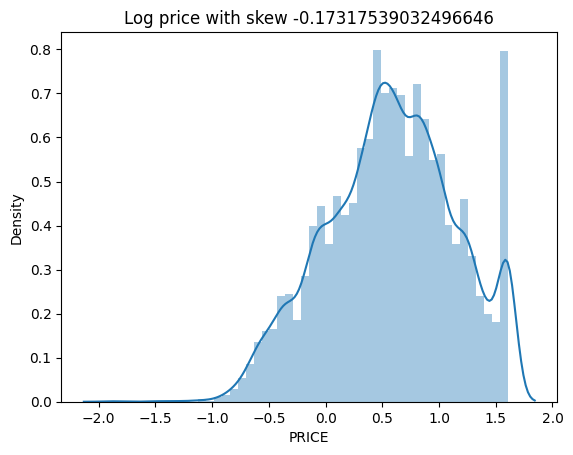

In [10]:
y_log.skew()
sns.distplot(y_log)
plt.title(f'Log price with skew {y_log.skew()}')

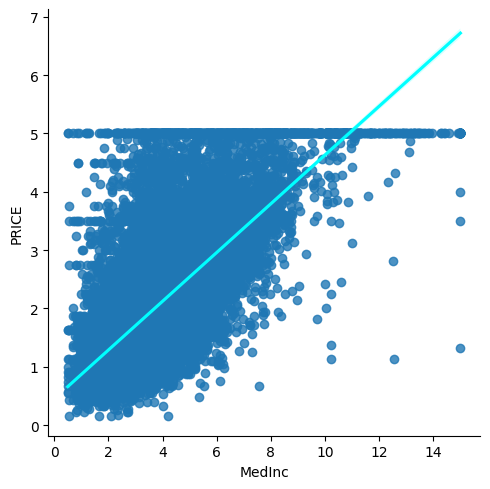

In [11]:
sns.lmplot(x='MedInc', y='PRICE',data=data, line_kws={'color':'cyan'})
plt.show()

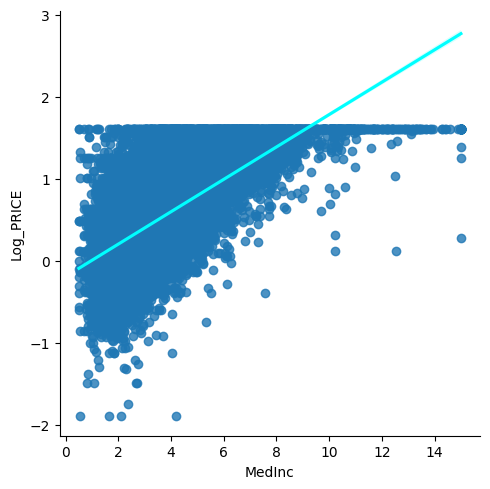

In [12]:
#Now we use the log prices
transformed_data=features
transformed_data['Log_PRICE'] = y_log
sns.lmplot(x='MedInc', y='Log_PRICE',data=transformed_data,line_kws={'color':'cyan'})
plt.show()

## Regression using log Prices

In [13]:
prices = np.log(data['PRICE'])
features = data.drop('PRICE', axis=1)
x_train,x_test,y_train,y_test = train_test_split(features,prices,test_size=0.2,random_state=10)

In [14]:
regr=LinearRegression()
regr.fit(x_train,y_train)
print('Training data r-squared:',regr.score(x_train,y_train))
print('Test data r-squared:', regr.score(x_test,y_test))
print('Intercept',regr.intercept_)
pd.DataFrame(data=regr.coef_,index=x_train.columns,columns=['coef'])


Training data r-squared: 0.6168233836099825
Test data r-squared: 0.603748925670488
Intercept -24.57049046084647


,coef
MedInc,0.186068
HouseAge,0.002279
AveRooms,-0.030865
AveBedrms,0.224873
Population,0.000008
AveOccup,-0.002259
Latitude,-0.289071
Longitude,-0.289146


In [15]:
np.e**(0.002279)

1.0022815988944185

In [16]:
x_incl_const = sm.add_constant(x_train)
model=sm.OLS(y_train,x_incl_const)
results = model.fit()
results.params

const        -24.570490
MedInc         0.186068
HouseAge       0.002279
AveRooms      -0.030865
AveBedrms      0.224873
Population     0.000008
AveOccup      -0.002259
Latitude      -0.289071
Longitude     -0.289146
dtype: float64

# Multicollinearity

# $$TAX = \alpha _0 + \alpha _1 RM + \alpha _2 NOX..... + \alpha_ {12}LSTAT $$

# $$VIF_{TAX} = \frac{1}{(1-R_{TAX}^2)}$$

In [17]:
variance_inflation_factor(exog=x_incl_const.values, exog_idx=1)

2.4741199441522226

In [18]:
#finding columns and rows
print(x_incl_const.shape)
print(x_incl_const.shape[1])

(16512, 9)
9


In [19]:
#loop for printing all the VIFs for all the features in a list
vif=[]
for i in range(x_incl_const.shape[1]):
    vif.append(variance_inflation_factor(exog=x_incl_const.values, exog_idx=i))
# print(vif)
#or
pd.DataFrame({'coef_name':x_incl_const.columns, 'vif':vif})

,coef_name,vif
0,const,17168.646399
1,MedInc,2.474120
2,HouseAge,1.240781
3,AveRooms,8.872377
4,AveBedrms,7.538103
5,Population,1.135597
6,AveOccup,1.008730
7,Latitude,9.383400
8,Longitude,9.043759


## Model Simplification

In [20]:
# BIC - Baysian Information Criterion  
#THe way to measue complexity. Lower, the better

In [21]:
#Orginal Model with log prices and all features
x_incl_const = sm.add_constant(x_train)
model = sm.OLS(y_train,x_incl_const)
results = model.fit()
org_coef = pd.DataFrame({'coef':results.params,'p-values':round(results.pvalues, 3)})
print('BIC is ',results.bic)
print('r-squared is',results.rsquared)

BIC is  12467.657146183055
r-squared is 0.6168233836099826


In [22]:
#Reduced Model #1 Excluding Population
x_incl_const = sm.add_constant(x_train)
x_incl_const = x_incl_const.drop(['Population'], axis=1)
model = sm.OLS(y_train,x_incl_const)
results = model.fit()
coef_minus_longitude = pd.DataFrame({'coef':results.params,'p-values':round(results.pvalues, 3)})
print('BIC is ',results.bic)
print('r-squared is',results.rsquared)

BIC is  12468.129145519348
r-squared is 0.6165869850077272


In [23]:
#Reduced Model #1 Excluding Population and Average Occupation
x_incl_const = sm.add_constant(x_train)
x_incl_const = x_incl_const.drop(['Population', 'AveOccup'], axis=1)
model = sm.OLS(y_train,x_incl_const)
results = model.fit()
reduced_coef = pd.DataFrame({'coef':results.params,'p-values':round(results.pvalues, 3)})
print('BIC is ',results.bic)
print('r-squared is',results.rsquared)

BIC is  12483.568192259281
r-squared is 0.6160025296869025


In [24]:
frames = [org_coef, coef_minus_longitude, reduced_coef]
pd.concat(frames,axis=1)

,coef,p-values,coef,p-values,coef,p-values
const,-24.570490,0.000,-24.622731,0.0,-24.682491,0.0
MedInc,0.186068,0.000,0.185910,0.0,0.185882,0.0
HouseAge,0.002279,0.000,0.002034,0.0,0.002009,0.0
AveRooms,-0.030865,0.000,-0.031243,0.0,-0.031355,0.0
AveBedrms,0.224873,0.000,0.225282,0.0,0.226002,0.0
Population,0.000008,0.001,NaN,NaN,NaN,NaN
AveOccup,-0.002259,0.000,-0.002142,0.0,NaN,NaN
Latitude,-0.289071,0.000,-0.290347,0.0,-0.290833,0.0
Longitude,-0.289146,0.000,-0.290135,0.0,-0.290731,0.0


# Residuals & Residual Plots

In [25]:
#modified model: Transformed (using log prices) & Simplified (dropping two featues)
#using price
prices = np.log(data['PRICE']) 
features = data.drop(['PRICE','AveOccup','Population'],axis=1)
x_train, x_test,y_train,y_test = train_test_split(features,prices,test_size=0.2, random_state=10)
#Using stasmodel
x_incl_const = sm.add_constant(x_train)
model = sm.OLS(y_train,x_incl_const)
results=model.fit()
# residuals = y_train - results.fittedvalues
# print(residuals)
# or
print(results.resid.head())

12346    0.387838
19326   -0.395915
16824   -0.104518
6869     0.085015
16677    0.061409
dtype: float64


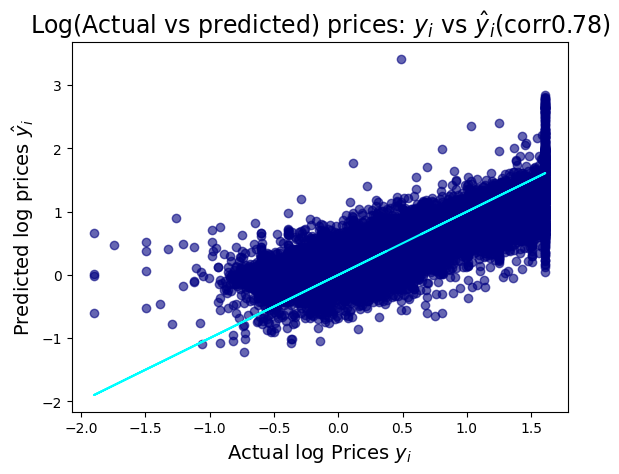

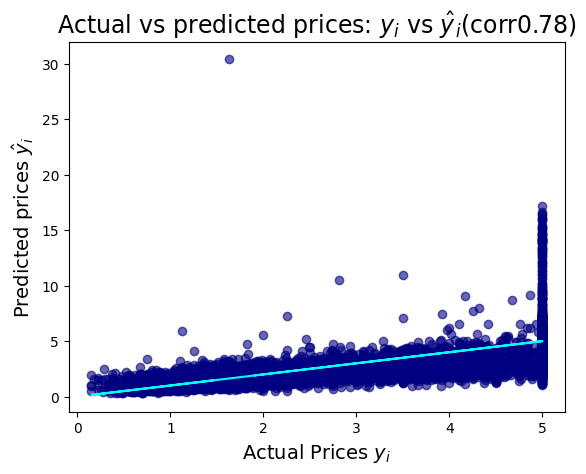

In [26]:
#Graph of Actual vs Predicted prices
corr = round(y_train.corr(results.fittedvalues),2)
plt.scatter(x=y_train,y=results.fittedvalues, c='navy',alpha=0.6)
plt.plot(y_train,y_train,color='cyan')
plt.xlabel('Actual log Prices $y _i$',fontsize=14)
plt.ylabel('Predicted log prices $\hat y _i$',fontsize=14)
plt.title(f'Log(Actual vs predicted) prices: $y _i$ vs $\hat y_i$(corr{corr})',fontsize=17)
plt.show()
#For Actual Price - Not log
plt.scatter(x=np.e**y_train,y=np.e**results.fittedvalues, c='navy',alpha=0.6)
plt.plot(np.e**y_train,np.e**y_train,color='cyan')
plt.xlabel('Actual Prices $y _i$',fontsize=14)
plt.ylabel('Predicted prices $\hat y _i$',fontsize=14)
plt.title(f'Actual vs predicted prices: $y _i$ vs $\hat y_i$(corr{corr})',fontsize=17)
plt.show()

### Residuals vs Predicted Values

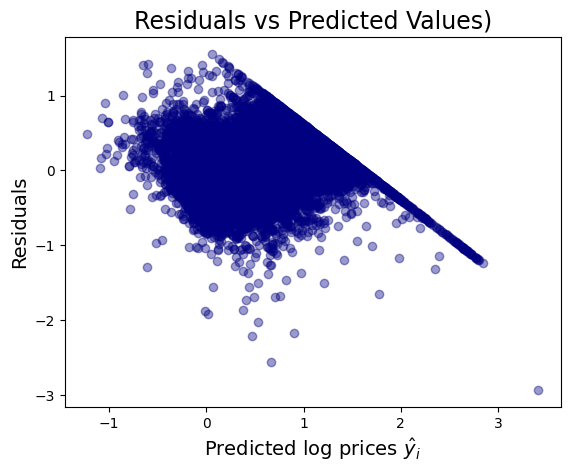

C:\Users\aadit\AppData\Local\Temp\ipykernel_8408\4277363349.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results.resid,color='navy')


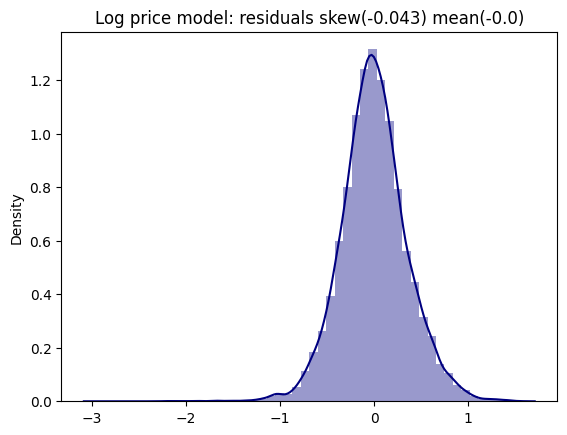

In [27]:
#Residuals can't be properly figured out. we only know how far are the data points
#Residuals vs Predicted Values
plt.scatter(x=results.fittedvalues,y=results.resid, c='navy',alpha=0.4)
plt.xlabel('Predicted log prices $\hat y _i$',fontsize=14)
plt.ylabel('Residuals',fontsize=14)
plt.title('Residuals vs Predicted Values)',fontsize=17)
plt.show()
#Normally distributing the Residuals
#Dristribution of Residuals(log Prices ) - checking for normality
resid_mean = round(results.resid.mean(),3)
resid_skew = round(results.resid.skew(),3)
sns.distplot(results.resid,color='navy')
plt.title(f'Log price model: residuals skew({resid_skew}) mean({resid_mean})')
plt.show()
reduced_log_mse = round(results.mse_resid,3)
reduced_log_rsquared = round(results.rsquared,3)

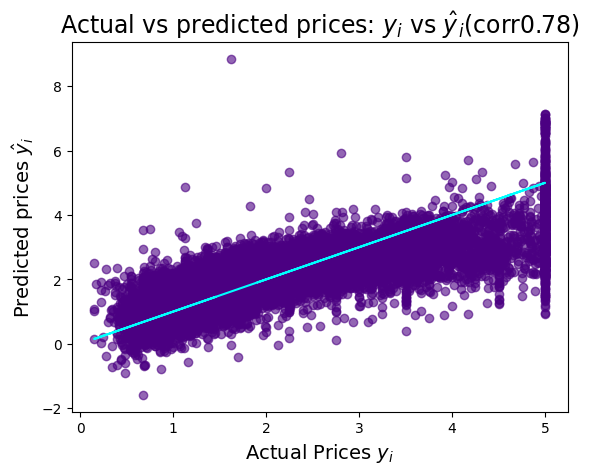

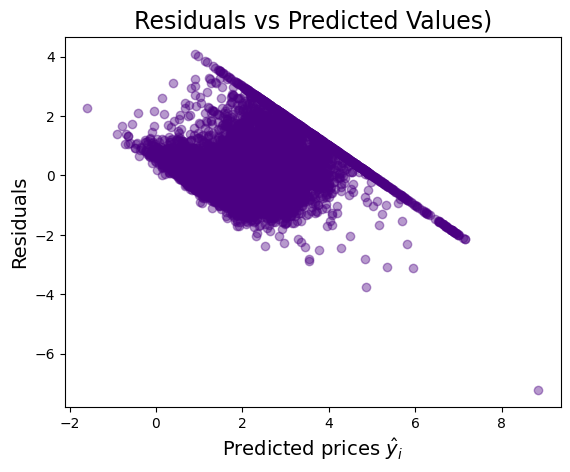

C:\Users\aadit\AppData\Local\Temp\ipykernel_8408\3634893971.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results.resid,color='indigo')


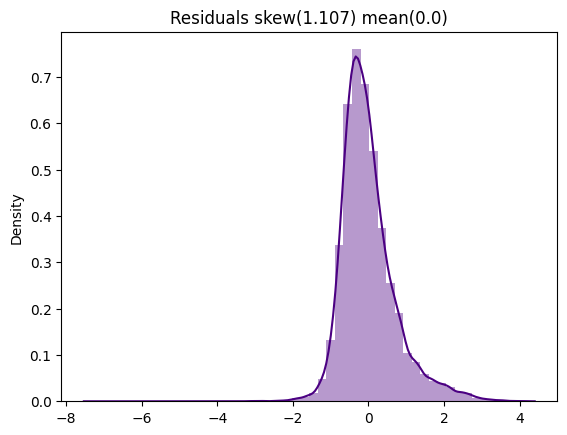

In [28]:
#We now use the original model with all the features ande normal prices generate:
#plot of actual prices vs predicted price
#plot of residuals vs predicted price
#plot of distribution of residuals
#
#
#original model: Normal price and all features
prices = data['PRICE']
features = data.drop(['PRICE'],axis=1)
x_train, x_test,y_train,y_test = train_test_split(features,prices,test_size=0.2, random_state=10)
x_incl_const = sm.add_constant(x_train)
model = sm.OLS(y_train,x_incl_const)
results=model.fit()

#Graph of Actual vs Predicted prices
corr = round(y_train.corr(results.fittedvalues),2)
plt.scatter(x=y_train,y=results.fittedvalues, c='indigo',alpha=0.6)
plt.plot(y_train,y_train,color='cyan')
plt.xlabel('Actual Prices $y _i$',fontsize=14)
plt.ylabel('Predicted prices $\hat y _i$',fontsize=14)
plt.title(f'Actual vs predicted prices: $y _i$ vs $\hat y_i$(corr{corr})',fontsize=17)
plt.show()


#Residuals vs Predicted Values
plt.scatter(x=results.fittedvalues,y=results.resid, c='indigo',alpha=0.4)
plt.xlabel('Predicted prices $\hat y _i$',fontsize=14)
plt.ylabel('Residuals',fontsize=14)
plt.title('Residuals vs Predicted Values)',fontsize=17)
plt.show()


#Dristribution of Residuals(log Prices ) - checking for normality
resid_mean = round(results.resid.mean(),3)
resid_skew = round(results.resid.skew(),3)
sns.distplot(results.resid,color='indigo')
plt.title(f'Residuals skew({resid_skew}) mean({resid_mean})')
plt.show()

full_normal_mse = round(results.mse_resid,3)
full_normal_rsquared = round(results.rsquared,3)

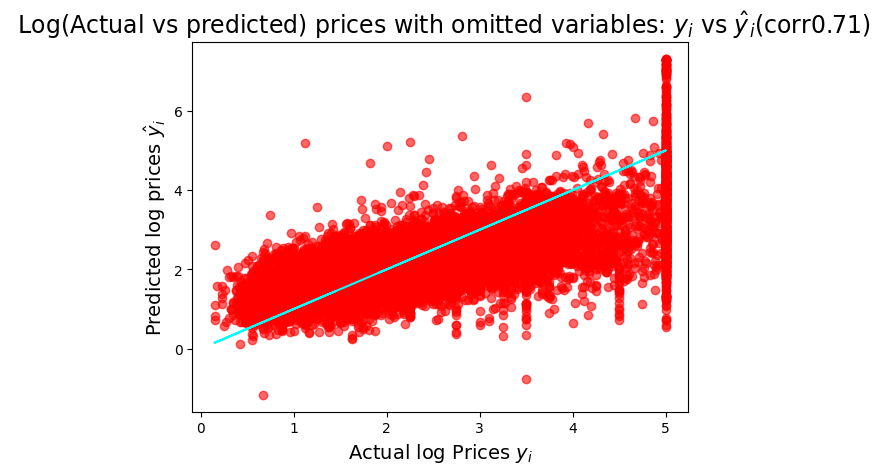

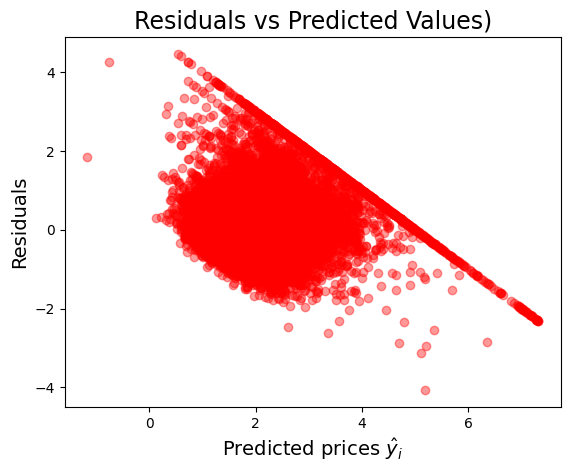

In [29]:
#Model Omitting key features using log prices
#original model: Normal price and all features
prices = data['PRICE']
features = data.drop(['PRICE','Longitude','Latitude','AveRooms','AveBedrms'],axis=1)
x_train, x_test,y_train,y_test = train_test_split(features,prices,test_size=0.2, random_state=10)
x_incl_const = sm.add_constant(x_train)
model = sm.OLS(y_train,x_incl_const)
results=model.fit()

#Graph of Actual vs Predicted prices
corr = round(y_train.corr(results.fittedvalues),2)
plt.scatter(x=y_train,y=results.fittedvalues, c='red',alpha=0.6)
plt.plot(y_train,y_train,color='cyan')
plt.xlabel('Actual log Prices $y _i$',fontsize=14)
plt.ylabel('Predicted log prices $\hat y _i$',fontsize=14)
plt.title(f' Log(Actual vs predicted) prices with omitted variables: $y _i$ vs $\hat y_i$(corr{corr})',fontsize=17)
plt.show()


#Residuals vs Predicted Values
plt.scatter(x=results.fittedvalues,y=results.resid, c='red',alpha=0.4)
plt.xlabel('Predicted prices $\hat y _i$',fontsize=14)
plt.ylabel('Residuals',fontsize=14)
plt.title('Residuals vs Predicted Values)',fontsize=17)
plt.show()

ommited_var_mse = round(results.mse_resid,3)
ommited_var_rsquared= round(results.rsquared,3)

In [30]:
pd.DataFrame({'R-squared':[reduced_log_rsquared, full_normal_rsquared,ommited_var_rsquared],
             'MSE':[reduced_log_mse, full_normal_mse,ommited_var_mse]}, index = ['Reduced log model', 'Full Normal Price Model', 'Ommitted variables model'])

,R-squared,MSE
Reduced log model,0.616,0.124
Full Normal Price Model,0.607,0.520
Ommitted variables model,0.511,0.647


# Root Mean Squared Error

In [33]:
#to create a range around our predicted price, we choose how wide do we want the interval to be.
#If we want 95% then we use 2 S.D... +- 2*RMSE
#else, if we want 68% then we use 1 S.D... +- RMSE
#
#In the previous DataFrame, we add RMSE..
pd.DataFrame({'R-squared':[reduced_log_rsquared, full_normal_rsquared,ommited_var_rsquared],
             'MSE':[reduced_log_mse, full_normal_mse,ommited_var_mse], 'RMSE': np.sqrt([reduced_log_mse, full_normal_mse,ommited_var_mse])}, index = ['Reduced log model', 'Full Normal Price Model', 'Ommitted variables model'])

,R-squared,MSE,RMSE
Reduced log model,0.616,0.124,0.352136
Full Normal Price Model,0.607,0.520,0.721110
Ommitted variables model,0.511,0.647,0.804363


In [32]:
#Calculating upperbound and lowerbound for house price of 300,000
print('1 S.D in log price is',np.sqrt(reduced_log_mse))
print('2 S.D in log price is',2*np.sqrt(reduced_log_mse))
upper_bound = np.log(3) + 2*np.sqrt(reduced_log_mse)
print('The upper bound in log prices for 95% prediction interval is', upper_bound)
print('The upper bound in normal prices is $',np.e**upper_bound*100000)
#
lower_bound = np.log(3) + 2**np.sqrt(reduced_log_mse)
print('The lower bound in log prices for 95% prediction in interval is', lower_bound)
print('The lower bound in normal prices is $',np.e**lower_bound*100000)

1 S.D in log price is 0.35213633723318016
2 S.D in log price is 0.7042726744663603
The upper bound in log prices for 95% prediction interval is 1.80288496313447
The upper bound in normal prices is $ 606712.5674197148
The lower bound in log prices for 95% prediction in interval is 2.3750616785226275
The lower bound in normal prices is $ 1075167.6313136558


### ERROR :

In [35]:
###___NOT__TO__USE___###
300000 + np.e**(2*np.sqrt(reduced_log_mse))*100000
#It is wrong.. As we need to add first... Only then we transform later.. We got as we transformed first then added...

502237.5224732383